/home/anuj/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Target- 178
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 1.3 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 3.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 2.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 4.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To upda

2024-03-30 23:27:49.501 
  command:

    streamlit run /home/anuj/.local/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


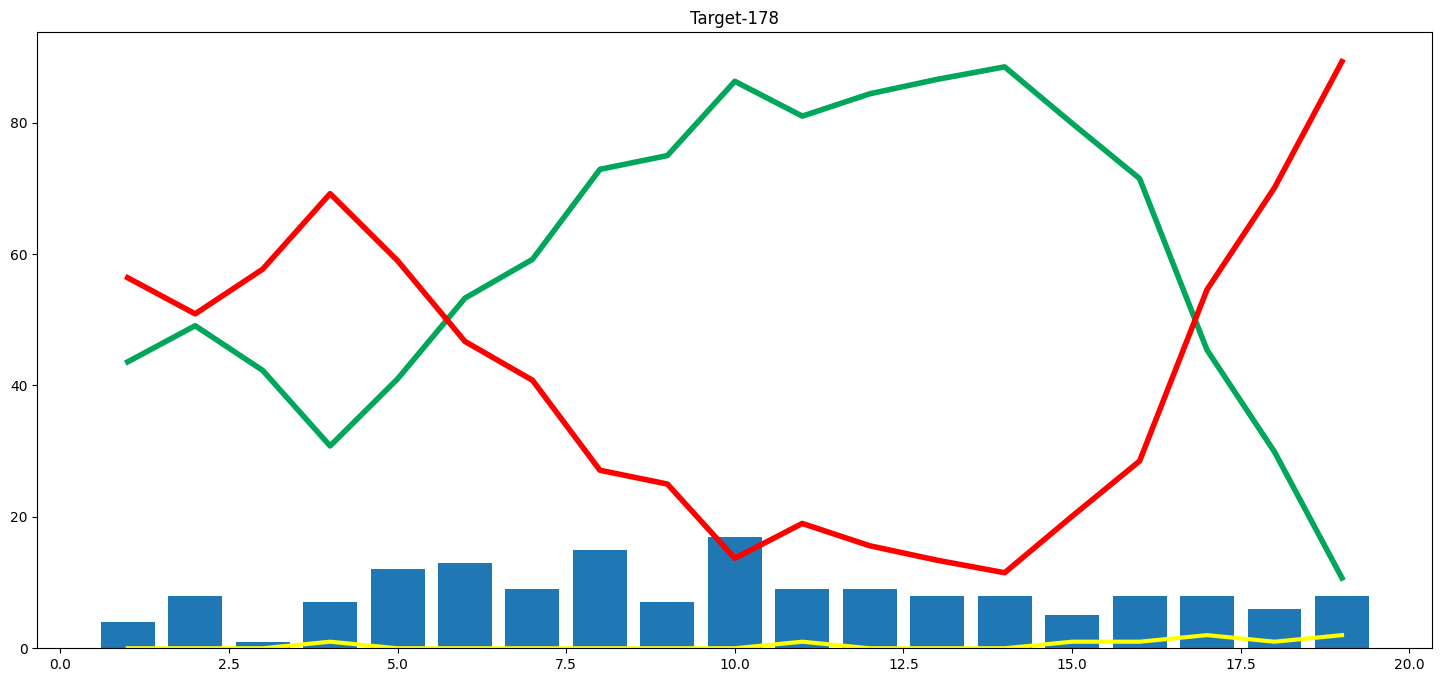

In [1]:
import numpy as np
import pandas as pd
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match.head()
match.shape
delivery.head()
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()  # total of  every inning
total_score_df = total_score_df[total_score_df['inning'] == 1]
total_score_df
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')
match_df
match_df['team1'].unique()
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]
match_df.shape
match_df = match_df[match_df['dl_applied'] == 0] # take only those match are not affected
match_df = match_df[['match_id','city','winner','total_runs']]
delivery_df = match_df.merge(delivery,on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]
delivery_df
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])
delivery_df
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets
delivery_df.head()
delivery_df.head()
# crr = runs/overs
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result,axis=1)
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]
final_df = final_df.sample(final_df.shape[0])
final_df.sample()
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
X_train
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)
pipe.predict_proba(X_test)[10]
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))
    
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    
temp_df,target = match_progression(delivery_df,74,pipe) # chasing team probability
temp_df
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))
teams
delivery_df['city'].unique()
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))
! pip install streamlit
import streamlit as st
import pickle
import pandas as pd

teams = ['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

cities = ['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', 'Mohali', 'Bengaluru']

pipe = pickle.load(open('pipe.pkl','rb'))
st.title('IPL Win Predictor')

col1, col2 = st.columns(2)


with col1:
    batting_team = st.selectbox('Select the batting team',sorted(teams))
with col2:
    bowling_team = st.selectbox('Select the bowling team',sorted(teams))

selected_city = st.selectbox('Select host city',sorted(cities))

target = st.number_input('Target')
col3, col4, col5 = st.columns(3)

with col3:
    score = st.number_input('Score')
with col4:
    overs = st.number_input('Overs completed')
with col5:
    wickets = st.number_input('Wickets out')

if st.button('Predict Probability'):
    runs_left = target - score
    balls_left = 120 - (overs*6)
    wickets = 10 - wickets
    crr = score/overs
    rrr = (runs_left*6)/balls_left

    input_df = pd.DataFrame({'batting_team':[batting_team],'bowling_team':[bowling_team],'city':[selected_city],'runs_left':[runs_left],'balls_left':[balls_left],'wickets':[wickets],'total_runs_x':[target],'crr':[crr],'rrr':[rrr]})

    result = pipe.predict_proba(input_df)
    loss = result[0][0]
    win = result[0][1]
    st.header(batting_team + "- " + str(round(win*100)) + "%")
    st.header(bowling_team + "- " + str(round(loss*100)) + "%")